In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

from pathlib import Path

# this adds the CANOSP root to the path, so we can import from there
import sys
sys.path.append('../')

# root of the repository
canosp_root_path = Path("./..")
data_path = canosp_root_path/"data"

In [2]:
from fastai.text import *

In [3]:
train = pd.read_csv(data_path/"train.csv")
train.head()

,ticket_id,bing,widget,pinterest,instagram,console,pdf,paypal,wikipedia,portal,...,allow,work,rendering,webpage,updated,apple,websites,opens,downloads,title_content
0,955006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,>
1,1066283,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,delete deleted
2,1233313,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,open new window letter n w right click menu mo...
3,1233322,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,web camera picture localhost 65 office picture...
4,1233348,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,firefox hang high cpu use try open local file ...


In [4]:
train['title_content'] = train['title_content'].str.replace('([“”¨«»®´·º½¾¿¡§£₤‘’])', '')

In [5]:
test = pd.read_csv(data_path/"test.csv")

test_id = test['ticket_id']
test['title_content'] = test['title_content'].str.replace('([“”¨«»®´·º½¾¿¡§£₤‘’])', '')

In [6]:
data = (TextList.from_df(train, cols="title_content")
                .split_by_rand_pct(0.2)
                .label_for_lm()  
                .databunch(bs=48))
data.show_batch()

idx,text
0,high cpu use unresponsive form xxunk kill task manager mean try include ff file open select html file ff use file : / / c : / window explorer context menu open > firefox window explorer drag html file firefox address bar window 10 64-bit win10 32-bit ff 62.0 64-bit xxunk late model dell laptop 16 gb memory xxunk xxunk intel graphic xxbos firefox crash open firefox crash startup safe
1,password xxunk work anymore issue make way abandon firefox xxbos possible set delay xxunk email like setup email firefox automatically xxunk far xxunk future xxbos firefox xxunk youtube video web page clear cache cooky unchecked hardware acceleration disable plugin delete cache cooky embed youtube video website blank white box safari chrome read thing web find wrong firefox difficult basic thing like view video website people need people look fix explain
2,find set window 10 ff startup list idea run xxunk version xxbos xxunk os instal xxunk ff add xxunk button work web page save option appear button work clear cache cooky try reinstall pinterest site bring right confirmation screen delete reinstall ff option work install button ff result save feature website button option save feature browser right click mouse world happen try turn protection site allow ad effect search time
3,want ask sign time open privacy security xxunk xxbos firefox.exe attempt connect xxunk hello total security software block suspicious connect firefox website xxunk follow message firefox.exe attempt establish connection rely xxunk security certificate xxunk block connection datum safe certificate issue different web address target find xxunk firefox xxunk redirect xxunk window 10 home 1803 late xxunk quantum 62.0.3 64-bit late update suggestion information xxunk xxbos remove firefox popup open new
4,site facebook account log facebook question self xxunk xxbos adjust font size print outlook.com come xxunk large 1 / 2 page turn 3 page explorer work fine time try print email font size super huge waste lot paper xxunk xxunk need print word normal try adjust setting print screen luck work perfectly fine explorer know printer like explorer think start happen update fix email print problem xxbos get download fail


In [7]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.3)

In [8]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


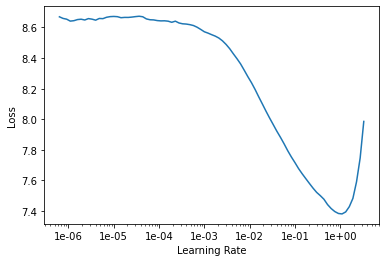

In [9]:
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,7.702434,6.009006,0.147867,00:01
1,6.635972,5.472787,0.163393,00:01
2,6.070879,5.324652,0.174256,00:01
3,5.673311,5.269908,0.174950,00:01
4,5.398365,5.262863,0.176240,00:01


In [11]:
learn.save_encoder('fine_tuned_enc')

In [12]:
with open(canosp_root_path/"candidate_tags/crowdtruth.csv") as f:
    candidate_tags = [line.strip() for line in f.readlines()]
    
candidate_tags.remove("firefox")
    
label_cols = candidate_tags
label_cols

['bing',
 'widget',
 'pinterest',
 'instagram',
 'console',
 'pdf',
 'paypal',
 'wikipedia',
 'portal',
 'cpu',
 'merge',
 'java',
 'twitch',
 'dashlane',
 'ebay',
 'bank',
 'zoom',
 'bad',
 'card',
 'aol',
 'twitter',
 'dns',
 'container',
 'autoplay',
 'youtube',
 'vpn',
 'xfinity',
 'facebook',
 'bookmarks',
 'pinned',
 'upload',
 'beta',
 'gmail',
 'locked',
 'tv',
 'tag',
 'flash',
 'amazon',
 'outlook',
 'keyboard',
 'master',
 'yahoo',
 'hyperlinks',
 'pictures',
 'hangs',
 'language',
 'english',
 'tracking',
 'google',
 'debian',
 'reader',
 'line',
 'speed',
 'drive',
 'search',
 'signature',
 'resize',
 'cloud',
 'menu',
 'javascript',
 'dark',
 'stream',
 'image',
 'sync',
 'restore',
 'picture',
 'logo',
 'html5',
 'videos',
 'secure',
 'freezes',
 'player',
 'bar',
 'fill',
 'monitor',
 'password',
 'black',
 'private',
 'toolbar',
 'history',
 'forum',
 'contrast',
 'paste',
 'font',
 'hacked',
 'purchase',
 'storage',
 'copy',
 'sidebar',
 'session',
 'colors',
 'emails

In [13]:
test_datalist = TextList.from_df(test, cols='title_content', vocab=data.vocab)

data_clas = (TextList.from_df(train, cols='title_content', vocab=data.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols=label_cols , classes=label_cols)
             .add_test(test_datalist)
             .databunch(bs=32))

data_clas.show_batch()

text,target
xxbos constant crash hello use browser anymore crash open background 1 tab start happen xxunk 2017 year attach report thank late happen try open browser time today submit crash xxunk would date xxunk xxunk xxunk xxunk 11 / 29 / 2018 xxunk xxunk xxunk xxunk xxunk xxunk 11 / 27 / 2018 xxunk xxunk xxunk xxunk xxunk xxunk 11 / 27 / 2018 xxunk pmbp xxunk 11 / 27 /,background;crash;open;mozilla;browser;crashes;id;unable
xxbos firefox crash start error show i 'm xxunk firefox xxunk edition and after one of the xxunk ( unsure xxunk one ) it does not xxunk after xxunk . after i click on firefox icon i xxunk see xxunk firefox xxunk in task manager xxunk after xxunk time xxunk xxunk quit xxunk xxunk xxunk window or even error message . i xxunk to enter safe mode xxunk xxunk shift,crash;crashing;app;edition;crashes;error;program;updates;updated
xxbos work mozilla firefox xxunk sabotage xxunk iran www.blib.ir xxunk log kill work xxunk authorize sodomy communist mainly gypsy atheist etc disbeliever terrorist hell iran force target xxunk xxunk compel xxunk authorize terrorist rule iranians iran intentionally deliberately torture till present time 01 / xxunk / 2015 trap force alike terrorist mainly terrorist xxunk xxunk alike slave rule iranians inhumane gypsy xxunk xxunk inhumane terrorist disbeliever atheist communist xxunk xxunk,hacked;server;browser;error
xxbos firefox crash firefox crash time especially xxunk think video card go buy new video xxunk xxunk uninstalled firefox reinstall firefox disable addons disable hardware xxunk problem browser xxunk list submit crash report report would date xxunk xxunk xxunk 10 / 31 / 2019 8:42 xxunk xxunk xxunk xxunk xxunk 10 / 31 / 2019 8:42 xxunk xxunk xxunk xxunk 10 / 31 / 2019 8:42 pmbp xxunk xxunk xxunk,facebook;memory;crash;stop;load;browser;error;working;addons
xxbos xxunk update xxunk complex session xxunk automatic refresh create old firefox datum folder desktop change firefox setting today xxunk update xxunk complex session xxunk automatic refresh create old firefox datum folder desktop change firefox setting window 10 pro 64-bit update present operation normal stable subject event minimize browser work email client thunderbird firefox default click link thunderbird normally xxunk come pass click click double click link xxunk xxunk xxunk,session;refresh;update;change;error;auto;automatic


In [14]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_classifier.load_encoder('fine_tuned_enc')
learn_classifier.freeze()

In [15]:
learn_classifier.lr_find()

epoch,train_loss,valid_loss,time
0,0.737821,#na#,00:04
1,0.897465,#na#,00:04


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


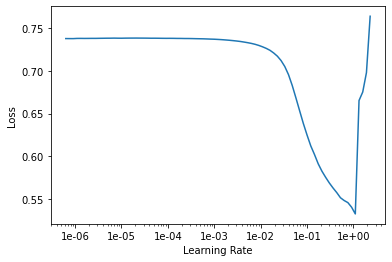

In [16]:
learn_classifier.recorder.plot()

In [17]:
learn_classifier.fit_one_cycle(6, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.542882,0.097257,00:04
1,0.202189,0.064081,00:04
2,0.111444,0.061619,00:04
3,0.079201,0.060403,00:04
4,0.066286,0.059644,00:04
5,0.060161,0.059483,00:04


In [18]:
learn_classifier.freeze_to(-2)
learn_classifier.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.059664,0.061662,00:04


In [19]:
learn_classifier.freeze_to(-3)
learn_classifier.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.057723,0.059687,00:04


In [22]:
learn_classifier.show_results(rows=1000)

text,target,prediction
xxbos xxunk disk xxunk observe 2 different platform sure believe see eye symptom day xxunk user initiate firefox installation configuration plugin change xxunk set website begin crash tab immediately page load reload website result xxunk crash website particular url crash tab load reload crash tab website set website crash tab xxunk restart firefox fix problem site crash tab restart disable xxunk fix problem observe mac os x laptop macbook pro,browsing;plugin;tabs;tab;crash;connection;ubuntu;disk;website;corrupt;crashes;error;linux;mac,
xxbos xxunk xxunk xxunk xxunk xxunk xxunk problem xxunk xxunk xxunk xxunk xxunk youtube.com xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk o xxunk xxunk xxunk xxunk xxunk . xxunk xxunk xxunk i xxunk xxunk : xxunk xxunk xxunk xxunk : xxunk xxunk xxunk xxunk : firefox xxunk xxunk xxunk xxunk i xxunk xxunk xxunk www.youtube.com xxunk xxunk xxunk xxunk xxunk . xxunk xxunk w xxunk xxunk ? xxunk xxunk,youtube;certificate;security;websites,
xxbos firefox crash startup firefox crash startup safe mode try download late version delete library application support file user set sort create mac user account firefox open fine new machine run mac os 10.14.2 able use firefox terminal setting change recall help font smooth mess dark mode option dark mode dock menu bar unsure setting relate think mention pretty brand new machine crash would xxunk xxunk xxunk xxunk xxunk xxunk,safe;mode;version;startup;latest;crashes;profiles,
xxbos issue create search plugin mycroft project plugin people mention submit search plugins mycroft project xxunk search site xxunk easy easy time eventually work long long xxunk screen post parameter change xxunk create url setting long json format problem result plain text json format url custom setting obfuscate see test plugins startpage mycroft obfuscate string post parameter search form url entry work fine create install 5 xxunk time start color,search;plugins;linux,
xxbos firefox change default paper size printer select hello little background info deal work store workstation workstation share printer star receipt printer brother size paper printer xxunk work issue able print system specific default printer setting change printer good issue xxunk xxunk star receipt printer set print xxunk select brother printer drop menu switch star receipt default paper size force letter cause receipt print like large sheet paper mean portion,printer;default;size;printing;change;wrong;printers,
xxbos need add on old version firefox not update browser not buy new hardware help people xxunk buy new xxunk computer hardware firefox force use new hardware new version need new hardware new add ons need new version browser xxunk xxunk add ons force buy new hardware xxunk mozilla non xxunk organization example iran internet xxunk xxunk government xxunk need free vpn add ons old version firefox especially xxunk thank,vpn;update;mozilla;hardware;new;browser;need,
xxbos paypal checkout popup window load indefinitely payment checkout paypal button website paypal popup window appear impossible progress checkout xxunk activate text securely log appear overlay spin wheel popup window continue indefinitely activate window progress enter email prompt window press possible login paypal separate tab xxunk popup behaviour look console popup unable find window xxunk xxunk error host window popup call console display fail execute xxunk xxunk target origin provide,paypal;window;payment;popup;websites,
xxbos xxunk late ff update adaware secure search show addon option remove window 10 pro version 1903 os build xxunk 70.0 64 bite let xxunk say work long time stump ff work fine 10 / 22 / 19 try open ff 10 / 23 / 19 keep crash start task find open safe mode see late ff update discover new addon install adaware secure search time review addons frequently try,search;secure;update;remove;uninstall;windows;addons;pro,
xxbos firefox xxunk esr work ok xxunk fail render math equation wikipedia work box .css 

In [21]:
preds, target = learn_classifier.get_preds(DatasetType.Test, ordered=True)
labels = preds.numpy()
preds, target

(tensor([[4.1517e-03, 7.7635e-05, 5.0061e-04,  ..., 6.2008e-02, 5.7701e-03,
          2.9410e-03],
         [6.4374e-04, 4.7955e-06, 1.3644e-04,  ..., 6.4038e-02, 5.7960e-04,
          2.7238e-04],
         [2.9558e-03, 1.7313e-05, 7.4165e-05,  ..., 8.3563e-03, 7.5690e-04,
          8.4420e-04],
         ...,
         [3.1128e-03, 1.6240e-04, 1.6709e-03,  ..., 1.9628e-01, 8.6993e-03,
          2.4417e-03],
         [7.9583e-03, 4.2749e-04, 2.3668e-03,  ..., 8.1203e-02, 2.1583e-02,
          5.8311e-03],
         [9.4921e-04, 7.6680e-05, 6.0239e-04,  ..., 1.3356e-01, 5.6066e-03,
          6.3079e-03]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0]))